In [8]:
# Import all required libraries.
import torch
import glob
import matplotlib.pylab as plt
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
from PIL import Image
from torchvision.models import resnet18
from torchvision import transforms, models
from sklearn.model_selection import StratifiedShuffleSplit
import os
import cv2
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image

In [9]:
# Filter out the warnings.
import warnings
warnings.filterwarnings("ignore")

In [10]:
# Check if CUDA is available.
# If so, assign the device to CUDA.
if torch.cuda.is_available():
    print("CUDA is available on this machine.")
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"Found CUDA-enabled device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available on this machine.")

CUDA is available on this machine.
Found CUDA-enabled device: NVIDIA GeForce RTX 2060


In [11]:
# Load image paths and store in an numpyp array, images.
images = glob.glob("../data/*/*/*")
images = np.array(images)

# Load the corresponding labels by splitting the file path on \ delimiter.
# Take the second from last entry in the array as the label.
labels = np.array([f.split("\\")[-2] for f in images])

# Get all unique classes from the label array.
classes = np.unique(labels).flatten()
print(classes)

['Bridge' 'Commercial' 'Industrial' 'Intersection' 'Landmark' 'Park'
 'Parking' 'Playground' 'Residential' 'Stadium']


In [12]:
class ResNet18(nn.Module):
    '''
    Pretrained CNN model to be used for image classification.
    '''
    def __init__(self, num_classes):
        # Initialize ResNet18 architecture.
        super(ResNet18, self).__init__()
        self.model = models.resnet18(pretrained=True)
        # Modify the fully connected later to output num_classes.
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        # Forward pass through the model.
        return self.model(x)

In [13]:
PATH = f'./saved_models/resnet18.pth'
model = ResNet18(len(classes))
model.to(device)
model.load_state_dict(torch.load(PATH))
model.eval()

ResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

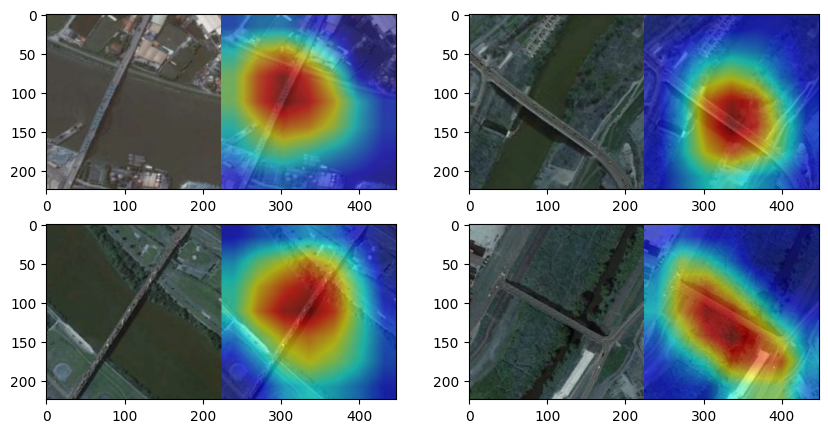

In [14]:
classDir = 'Bridge'
images_dir = f'../data/test/{classDir}/'

# List all files in the directory
all_files = os.listdir(images_dir)

# Filter out the first set of images
image_paths = []
for file in all_files:
    if file.endswith('.jpg'):
        image_paths.append(os.path.join(images_dir, file))
    if len(image_paths) >= 4:
        break

# Set model to eval
model.eval()

# Define the targets and target layers for GradCAM
targets = [ClassifierOutputTarget(np.where(classes == f'{classDir}')[0][0])] 
target_layers = [model.model.layer4] 

# Initialize lists to store images and heatmaps
images_list = []
heatmaps_list = []

# Generate GradCAM heatmaps for each image
for img_path in image_paths:
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    with GradCAM(model=model, target_layers=target_layers) as cam: 
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets) 
        cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True) 
        
    cam = np.uint8(255 * grayscale_cams[0])
    cam = cv2.resize(cam, (224, 224))
    
    images_list.append(np.uint8(255*img))
    heatmaps_list.append(cam_image)

# Create a grid of images
num_images = len(image_paths)
num_cols = 2
num_rows = (num_images + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(np.hstack((images_list[i], heatmaps_list[i])))
    else:
        ax.axis('off')

plt.show()